In [206]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="26"

In [207]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [208]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [209]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  4939c012-bfa9-42d5-ac10-608c2a64513d  2017-12-25T02:37:49Z   
1  7aecff4a-08f0-42f9-a1a2-ed84c1d2eeb3  2018-01-05T20:53:57Z   
2  e52848f7-f4bd-4a5f-921b-7f3df195aaa2  2017-10-30T00:35:11Z   
3  c969d120-f1b1-4664-804e-a76694c3db8e  2017-10-10T02:15:29Z   
4  a1c0713d-614a-4f75-9d6a-bd3629396bc3  2017-12-31T09:45:17Z   

                           request_id  partner_id origin destination  \
0  UK8COLYrKzT1tADDMx5dpmUI07mwh4nQcs          26    NRT         BNE   
1  lQJhQaP2HR0TCOSISfYdB0305FLzbKZZQD          26    MEL         LAX   
2  wrao2yNbFxLjC4eHd1MGBDwiwlbe7S7UnX          26    CBR         ADL   
3  lSzJ6YiVsfPHd2Uradismi2doDW9av4CS2          26    PER         ADL   
4  iVByZItv7NmdL5Od5V7LZqKYE4v0B7Czo1          26    SYD         AKL   

   flight_number departure_date departure_time currency     ...      \
0             62     2017-12-28          19:30      JPY     ...       
1             93     2018-02-01          11:15      USD     ...       
2            713     2017-11-03          06:00      AUD     ...       
3            592     2017-10-14          12:55      AUD     ...       
4            143     2018-01-17          10:15      NZD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5      550      4448             mi       333         1111.0   
1           5      860      7936             mi       388         2972.0   
2           5      105       603             mi       73H          316.0   
3           5      170      1316             mi       73H          428.0   
4           5      185      1343             mi       333         1030.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0         1111.0           1111.0          NaN         NaN  
1          495.0           1737.0          NaN         NaN  
2          149.0            223.0          NaN         NaN  
3          214.0            304.0          NaN         NaN  
4          171.0            601.0          NaN         NaN  

[5 rows x 33 columns]

In [210]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176839 entries, 0 to 176838
Data columns (total 33 columns):
event_id                              176839 non-null object
event_time                            176839 non-null object
request_id                            176839 non-null object
partner_id                            176839 non-null int64
origin                                176839 non-null object
destination                           176839 non-null object
flight_number                         176839 non-null int64
departure_date                        176839 non-null object
departure_time                        176839 non-null object
currency                              176839 non-null object
pnr                                   176839 non-null object
language                              176839 non-null object
pax                                   176839 non-null int64
eligibility                           176839 non-null bool
point_of_sale                         17

In [211]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [212]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
176834  2017-11-18T00:51:22Z          26    SYD         SFO             73   
176835  2017-11-03T07:38:16Z          26    SYD         PER            571   
176836  2017-11-26T23:55:00Z          26    ADL         MEL            684   
176837  2018-03-02T02:32:29Z          26    DFW         SYD              8   
176838  2018-01-14T05:48:03Z          26    PER         BNE            594   

       departure_date departure_time currency language  pax   ...    \
176834     2017-12-15          17:55      AUD       en    1   ...     
176835     2017-11-06          17:45      AUD       en    1   ...     
176836     2017-12-01          13:55      AUD       en    1   ...     
176837     2018-03-07          20:00      USD       en    2   ...     
176838     2018-01-21          16:25      AUD       en    1   ...     

        upgrade_type duration distance equipment slider_max_usd  \
176834      BUSINESS      810     7433       744         2270.0   
176835      BUSINESS      295     2039       332          272.0   
176836      BUSINESS       80      399       73H          209.0   
176837      BUSINESS     1025     8589       388         2561.0   
176838      BUSINESS      270     2241       73H          435.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
176834          378.0           1324.0      378.2909    3871518.0    True  
176835           92.0            180.0      118.0627    2211764.0    True  
176836           91.0            148.0       92.2765    3896492.0    True  
176837          426.0           1498.0      450.0000    4222121.0    True  
176838          217.0            308.0      251.1658    3963291.0    True  

[5 rows x 26 columns]

In [213]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    176839.0  176839.000000  176839.000000  176839.000000  176839.000000   
mean         26.0     455.037661       1.361199     352.072139    2780.257494   
std           0.0     394.072596       0.740696     341.912462    3018.580891   
min          26.0       1.000000       1.000000      55.000000     147.000000   
25%          26.0      79.000000       1.000000      95.000000     465.000000   
50%          26.0     476.000000       1.000000     195.000000    1343.000000   
75%          26.0     664.000000       2.000000     550.000000    4599.000000   
max          26.0    1795.000000       9.000000    1375.000000   10587.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   176839.000000   176839.000000     176839.000000  35368.000000   
mean      1176.824456      263.320059        716.713095    332.968832   
std       1452.821872      240.096644        837.265924    353.885108   
min         92.000000       44.000000         85.000000     43.642200   
25%        217.000000       94.000000        154.000000    124.038125   
50%        420.000000      165.000000        298.000000    215.402850   
75%       1691.000000      382.000000       1132.000000    421.203875   
max       6461.000000     1178.000000       3768.000000   6331.001000   

        customer_id  
count  3.536800e+04  
mean   3.660231e+06  
std    5.792709e+05  
min    2.108927e+06  
25%    3.520837e+06  
50%    3.862067e+06  
75%    4.056810e+06  
max    4.288356e+06

In [214]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 176839  176839      176839         176839   
unique                143388      46          46            343   
top     2018-03-16T19:26:28Z     SYD         SYD     2017-12-22   
freq                       8   45062       50446           1579   

       departure_time currency language point_of_sale    channel_source  \
count          176839   176839   176839        176839            176839   
unique            232        7        2            45                11   
top             11:35      AUD       en            AU  PRE_TRAVEL_EMAIL   
freq             3864   148940   174289        120913            104407   

       carrier_code fare_class from_cabin upgrade_type equipment  
count        176839     176839     176839       176839    176839  
unique            1         15          2            2         7  
top              QF          Q    ECONOMY     BUSINESS       73H  
freq         176839      40960     169578       159335     89076

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176839 entries, 0 to 176838
Data columns (total 26 columns):
event_time          176839 non-null object
partner_id          176839 non-null int64
origin              176839 non-null object
destination         176839 non-null object
flight_number       176839 non-null int64
departure_date      176839 non-null object
departure_time      176839 non-null object
currency            176839 non-null object
language            176839 non-null object
pax                 176839 non-null int64
eligibility         176839 non-null bool
point_of_sale       176839 non-null object
channel_source      176839 non-null object
carrier_code        176839 non-null object
fare_class          176839 non-null object
from_cabin          176839 non-null object
upgrade_type        176839 non-null object
duration            176839 non-null int64
distance            176839 non-null int64
equipment           176839 non-null object
slider_max_usd      176839 non-null 

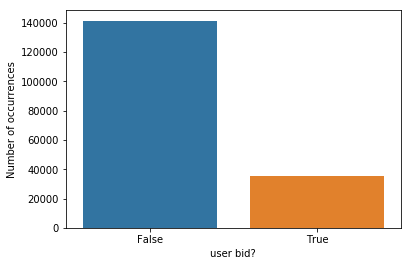

Has_bid percentage: 25.00%


In [216]:
#What is the distribution of has bid
sns.countplot(df.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

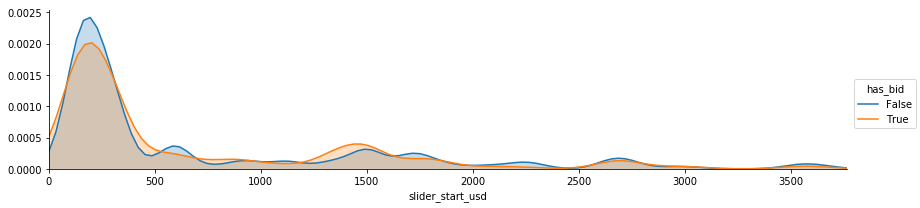

In [217]:
plot_distribution( df , var = 'slider_start_usd' , target = 'has_bid' )

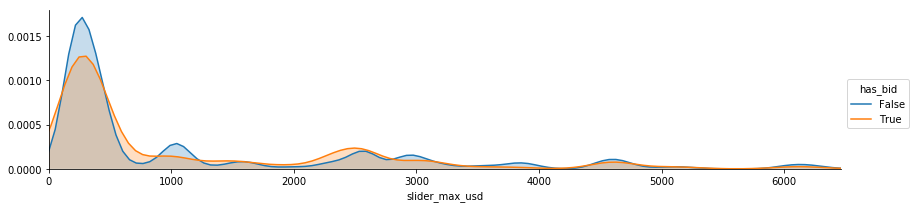

In [218]:
plot_distribution( df , var = 'slider_max_usd' , target = 'has_bid' )

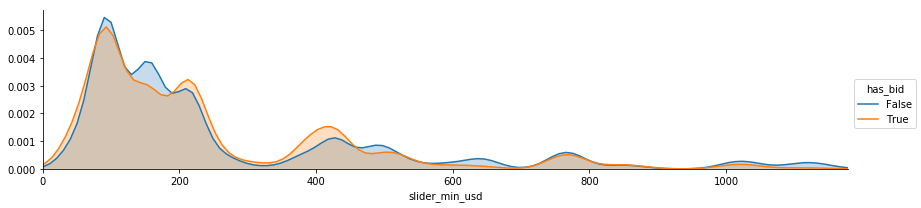

In [219]:
plot_distribution( df , var = 'slider_min_usd' , target = 'has_bid' )

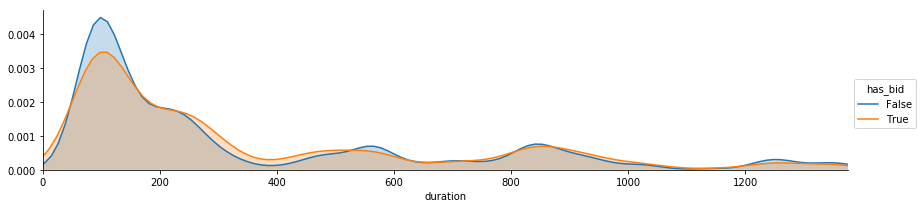

In [220]:
plot_distribution( df , var = 'duration' , target = 'has_bid' )

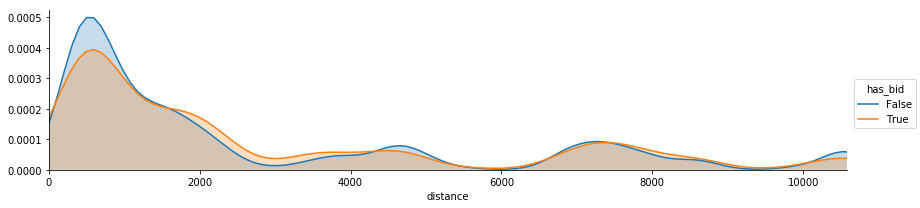

In [221]:
plot_distribution( df , var = 'distance' , target = 'has_bid' )

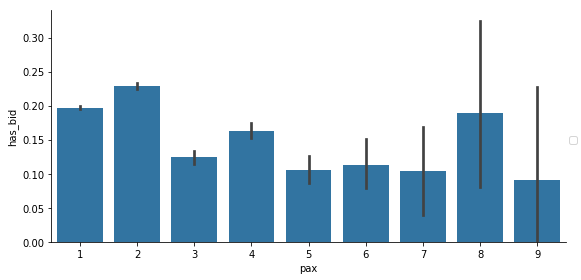

In [222]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

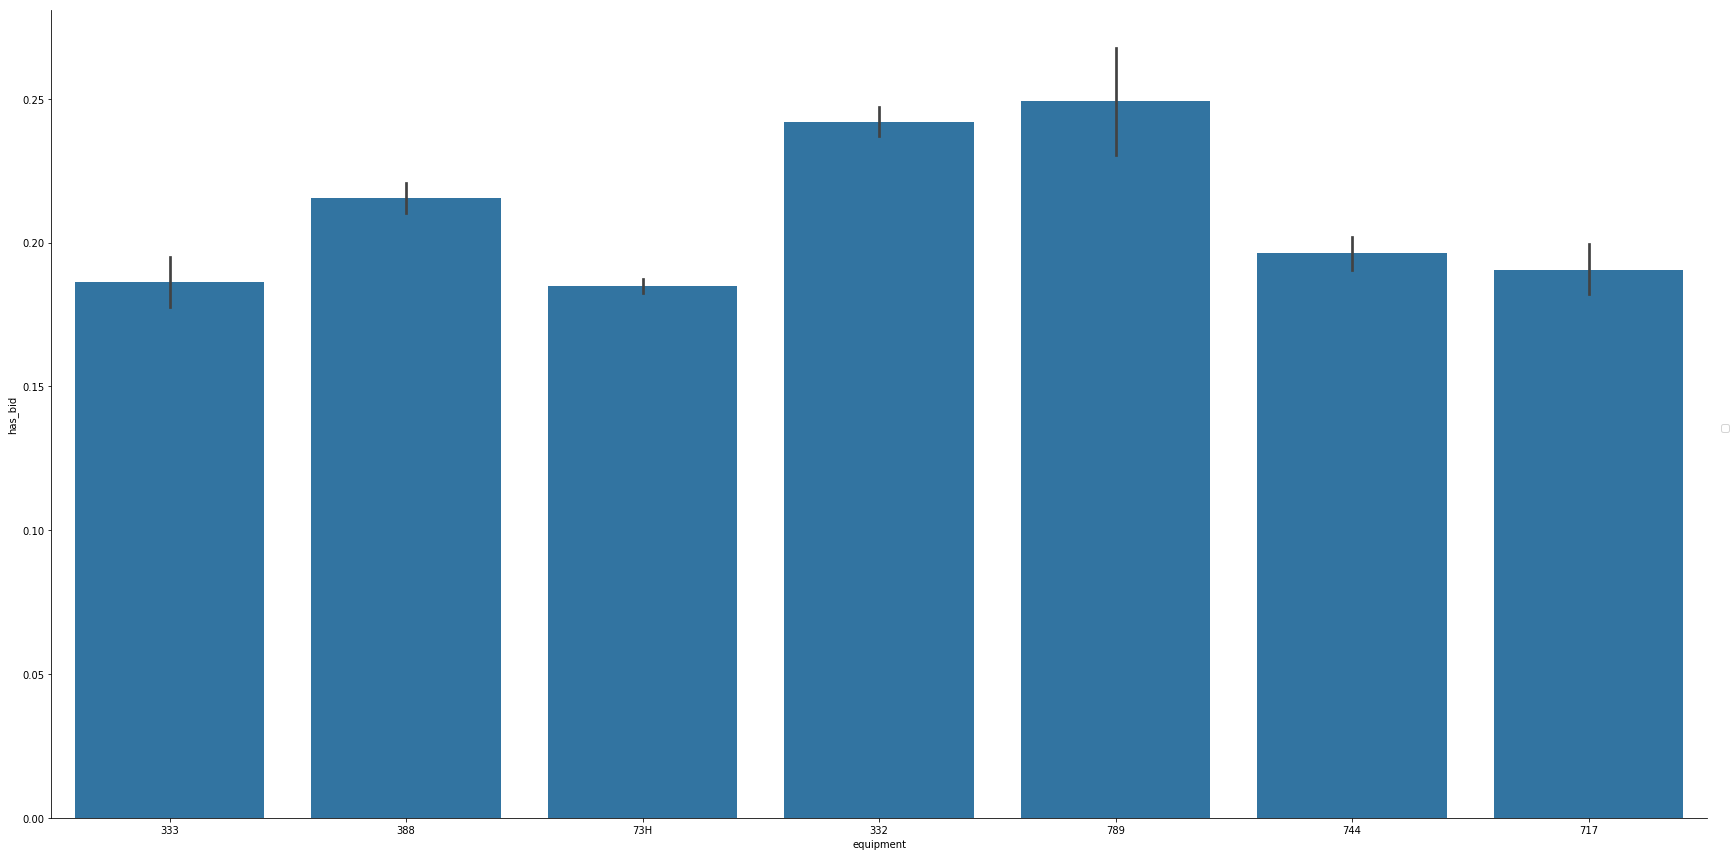

In [223]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

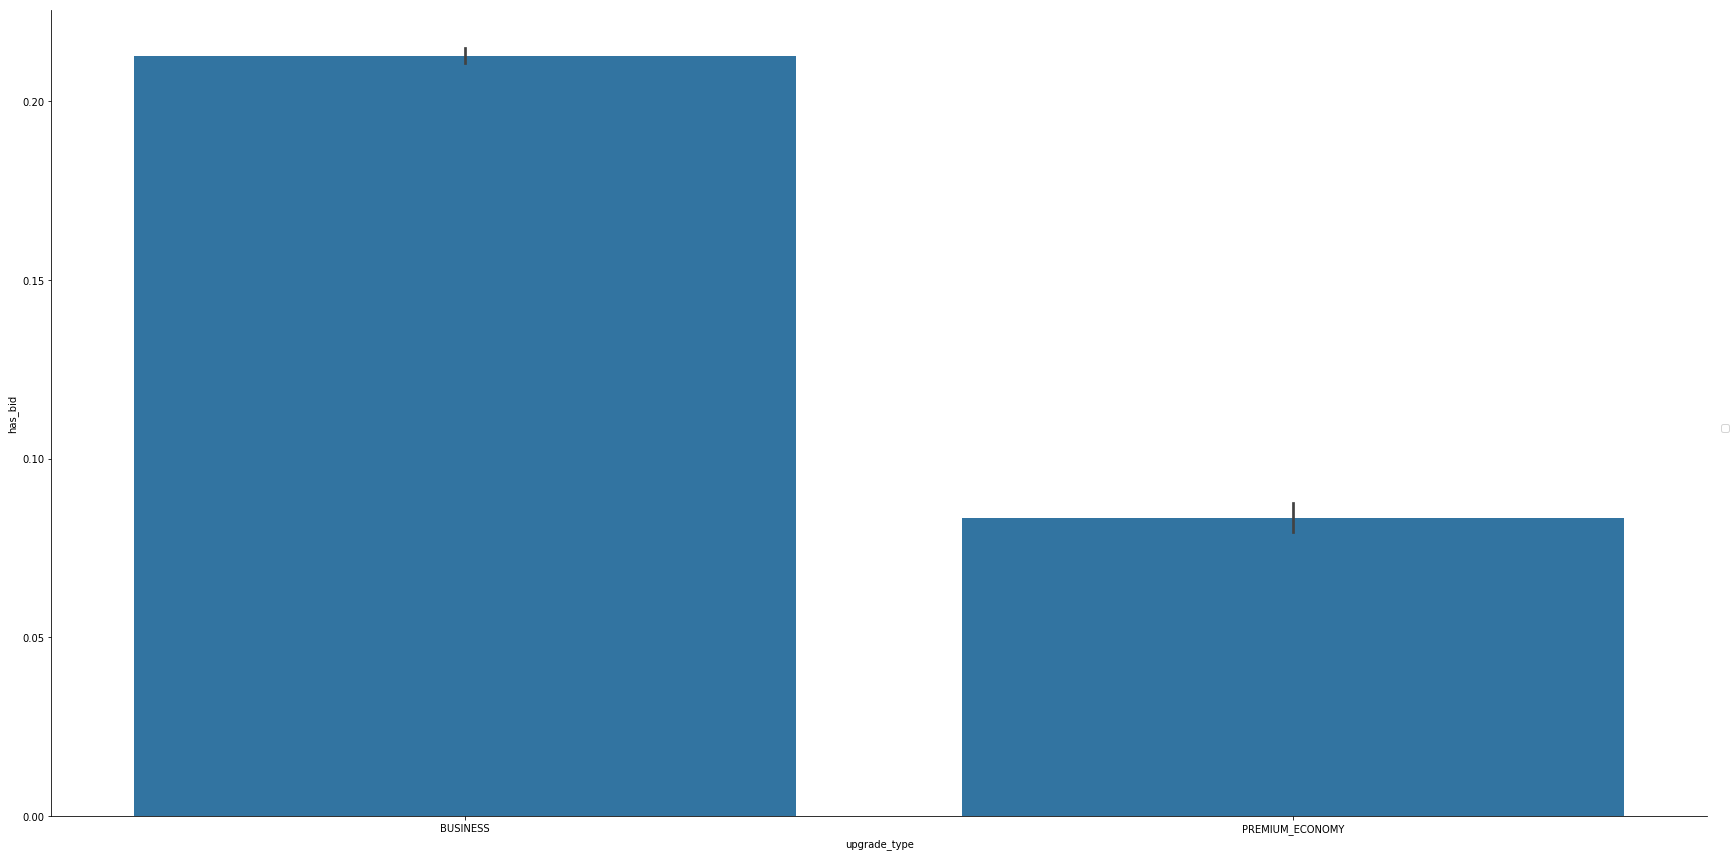

In [224]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

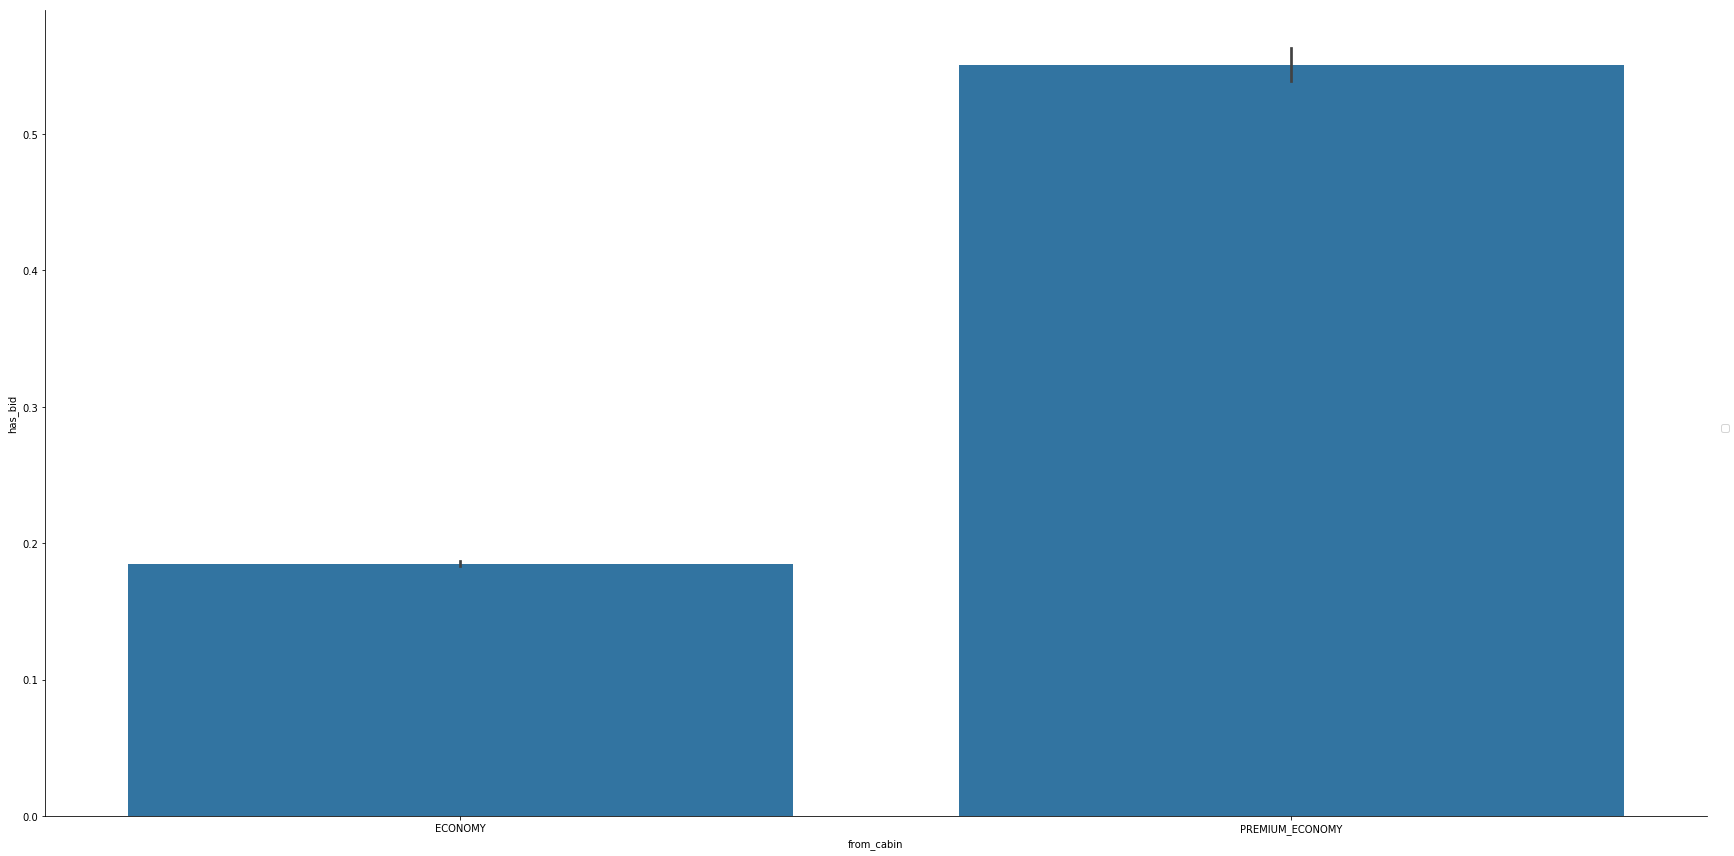

In [225]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

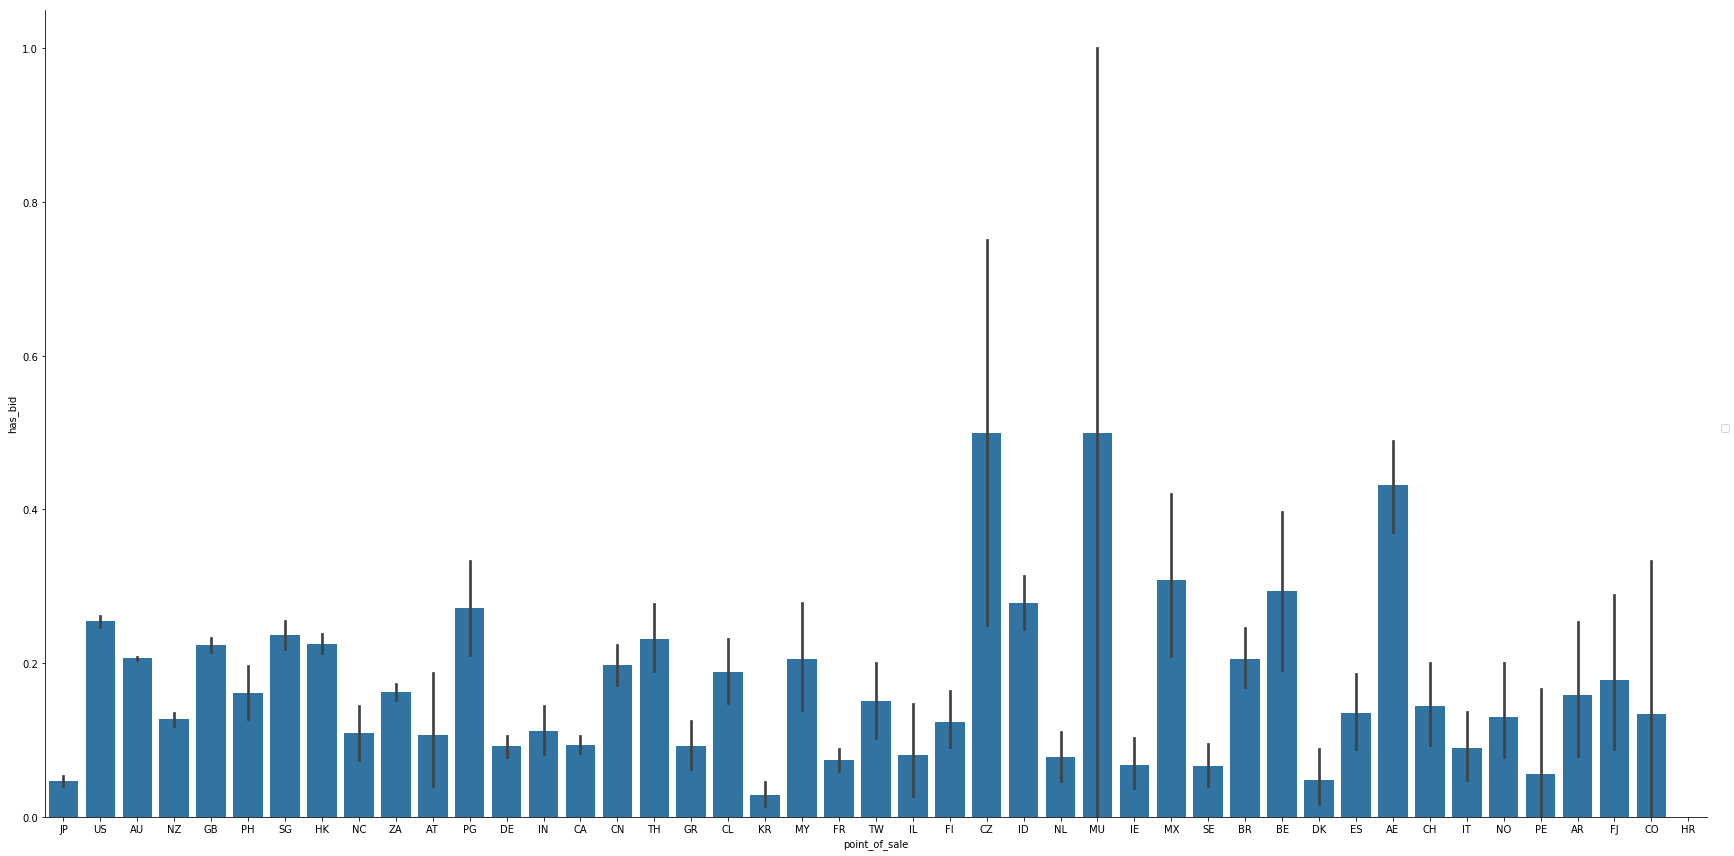

In [226]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

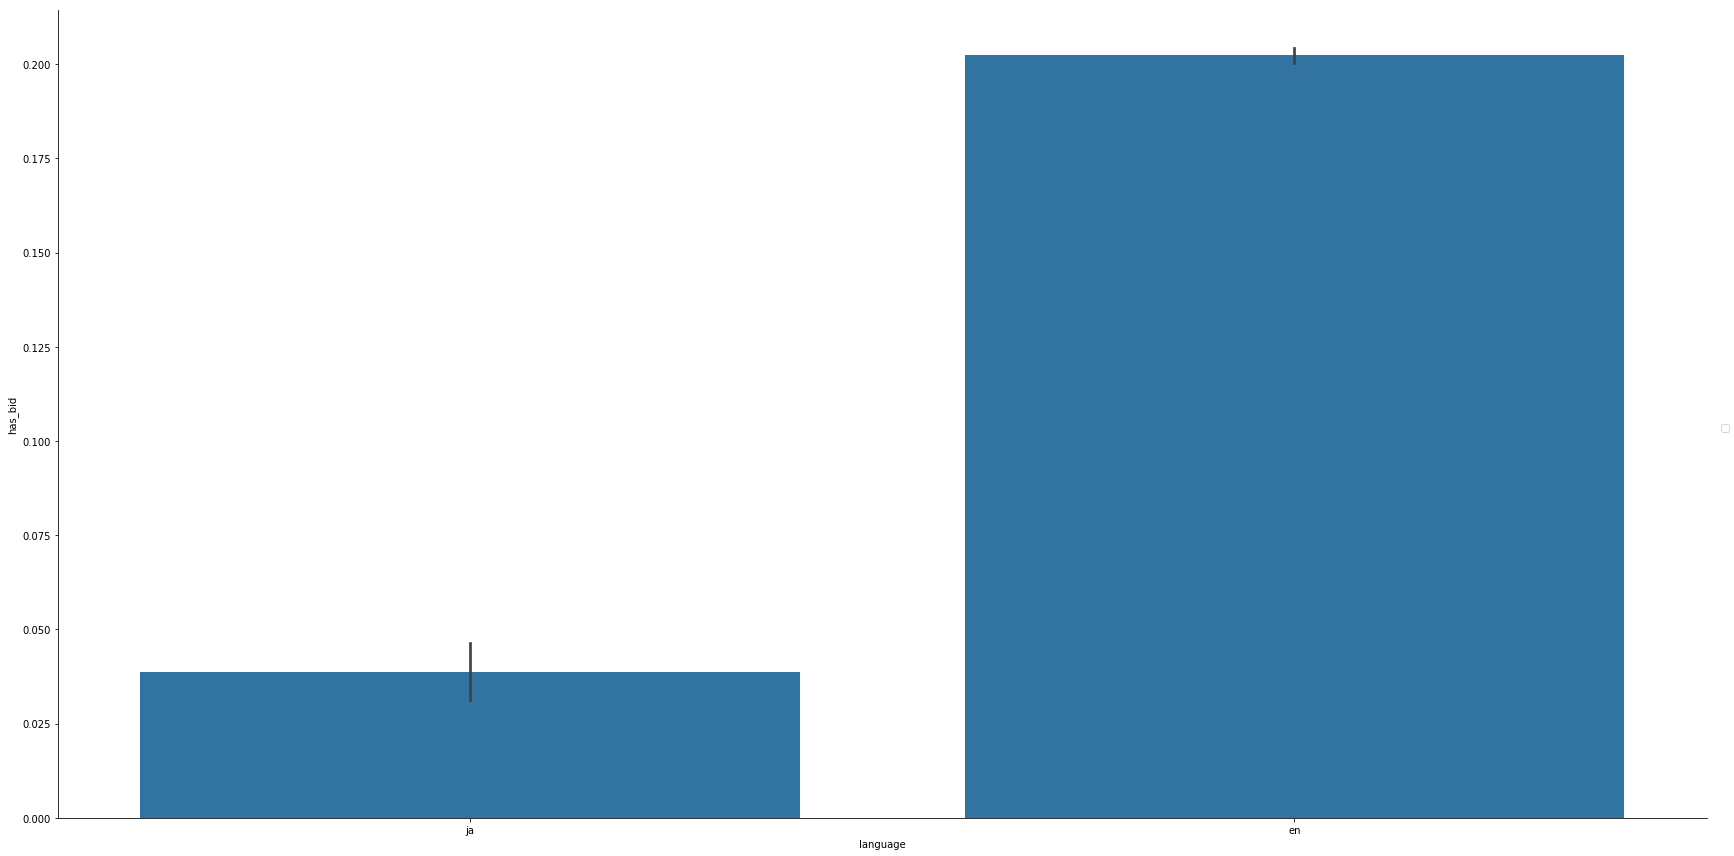

In [227]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [228]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [229]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176839 entries, 0 to 176838
Data columns (total 26 columns):
event_time          176839 non-null object
partner_id          176839 non-null int64
origin              176839 non-null object
destination         176839 non-null object
flight_number       176839 non-null float32
departure_date      176839 non-null object
departure_time      176839 non-null object
currency            176839 non-null object
language            176839 non-null object
pax                 176839 non-null float32
eligibility         176839 non-null bool
point_of_sale       176839 non-null object
channel_source      176839 non-null object
carrier_code        176839 non-null object
fare_class          176839 non-null object
from_cabin          176839 non-null object
upgrade_type        176839 non-null object
duration            176839 non-null float32
distance            176839 non-null float32
equipment           176839 non-null object
slider_max_usd      176839 n

### Prepare dataset

In [230]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
leOrigin = preprocessing.LabelEncoder()
leDestination = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    leDestination.fit(train_df_fact["destination"])
    train_df_fact["destination"] = leDestination.transform(train_df_fact["destination"])
    leOrigin.fit(train_df_fact["origin"])
    train_df_fact["origin"] = leOrigin.transform(train_df_fact["origin"])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [231]:
#factorize the categorical fields
columns_cat = ["equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [232]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176839 entries, 0 to 176838
Data columns (total 26 columns):
event_time          176839 non-null object
partner_id          176839 non-null int64
origin              176839 non-null int64
destination         176839 non-null int64
flight_number       176839 non-null int64
departure_date      176839 non-null object
departure_time      176839 non-null int64
currency            176839 non-null int64
language            176839 non-null int64
pax                 176839 non-null float32
eligibility         176839 non-null bool
point_of_sale       176839 non-null int64
channel_source      176839 non-null int64
carrier_code        176839 non-null int64
fare_class          176839 non-null int64
from_cabin          176839 non-null int64
upgrade_type        176839 non-null int64
duration            176839 non-null float32
distance            176839 non-null float32
equipment           176839 non-null int64
slider_max_usd      176839 non-null float3

## Create a model and evaluation

In [233]:
#Function utils
from sklearn.linear_model import LogisticRegression

random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


In [243]:
origins = train_df_3.origin.unique()
destinations = train_df_3.destination.unique()

def getTestDatasetsByRoute(testDatasetsX, testDatasetsY):
    datasetsByRouteX = []
    datasetsByRouteY = []
    origins_labels = []
    destinations_labels = []
    for i in origins:
        for j in destinations:
            idx = (testDatasetsX['origin'] == i) & (testDatasetsX['destination'] == j)
            datasetsByRouteX.append(testDatasetsX.loc[idx].copy())
            datasetsByRouteY.append(testDatasetsY.loc[idx].copy())
            origins_labels.append(i)
            destinations_labels.append(j)
    return datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels
    

def do_train_and_validate_by_route(df_to_train, n_splits = 2):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    X_train, X_valid, y_train, y_valid = train_test_split(x,y, test_size=0.30, random_state=42)
    random_forest.fit(X_train, y_train)
    datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels = getTestDatasetsByRoute(X_valid, y_valid)
    results = []
    for idx, val in enumerate(datasetsByRouteX):
        if (datasetsByRouteX[idx].shape[0] > 500):
            Y_test_pred = random_forest.predict_proba(datasetsByRouteX[idx])[:,1]
            fpr, tpr, _ = metrics.roc_curve(datasetsByRouteY[idx].astype(int), Y_test_pred)
            results.append([metrics.auc(fpr, tpr), leOrigin.inverse_transform(origins_labels[idx]), leDestination.inverse_transform(destinations_labels[idx])])
    results.sort(key=lambda x: x[0], reverse = True)
    for result in results:
        print("AUC = {}, ORIGIN = {}, DESTINATION = {}".format(result[0], result[1], result[2]))
    return results



### Feature engineering

In [235]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = train_df2.copy()

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


In [236]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176839 entries, 0 to 176838
Data columns (total 28 columns):
event_time               176839 non-null object
partner_id               176839 non-null int64
origin                   176839 non-null int64
destination              176839 non-null int64
flight_number            176839 non-null int64
departure_date           176839 non-null object
departure_time           176839 non-null int64
currency                 176839 non-null int64
language                 176839 non-null int64
pax                      176839 non-null float32
eligibility              176839 non-null bool
point_of_sale            176839 non-null int64
channel_source           176839 non-null int64
carrier_code             176839 non-null int64
fare_class               176839 non-null int64
from_cabin               176839 non-null int64
upgrade_type             176839 non-null int64
duration                 176839 non-null float32
distance                 176839 non-nu

In [237]:
train_df_3 = train_df_fact2.drop(["partner_id","eligibility", "departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "customer_id", "offer_amount"], axis=1)

In [238]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176839 entries, 0 to 176838
Data columns (total 18 columns):
origin                   176839 non-null int64
destination              176839 non-null int64
flight_number            176839 non-null int64
departure_time           176839 non-null int64
currency                 176839 non-null int64
pax                      176839 non-null float32
channel_source           176839 non-null int64
carrier_code             176839 non-null int64
fare_class               176839 non-null int64
duration                 176839 non-null float32
distance                 176839 non-null float32
equipment                176839 non-null int64
slider_max_usd           176839 non-null float32
slider_min_usd           176839 non-null float32
slider_start_usd         176839 non-null float32
has_bid                  176839 non-null bool
days_before_departure    176839 non-null int64
destination_origin       176839 non-null int64
dtypes: bool(1), float32(6), int

In [244]:
validationResults = do_train_and_validate_by_route(train_df_3)

AUC = 0.7636921435240762, ORIGIN = SYD, DESTINATION = LHR
AUC = 0.7621814854974247, ORIGIN = DFW, DESTINATION = SYD
AUC = 0.7548275113907572, ORIGIN = MEL, DESTINATION = LHR
AUC = 0.7500529773257045, ORIGIN = LHR, DESTINATION = MEL
AUC = 0.7429679168147885, ORIGIN = LAX, DESTINATION = SYD
AUC = 0.7376344086021506, ORIGIN = SYD, DESTINATION = HKG
AUC = 0.7221982176613556, ORIGIN = LAX, DESTINATION = MEL
AUC = 0.7221564843806888, ORIGIN = MEL, DESTINATION = LAX
AUC = 0.7188306246199859, ORIGIN = SYD, DESTINATION = DFW
AUC = 0.710277393984483, ORIGIN = SYD, DESTINATION = JNB
AUC = 0.7015045409782252, ORIGIN = HKG, DESTINATION = SYD
AUC = 0.6961781357011338, ORIGIN = LHR, DESTINATION = SYD
AUC = 0.6939480937069362, ORIGIN = JNB, DESTINATION = SYD
AUC = 0.6715404394576905, ORIGIN = CBR, DESTINATION = MEL
AUC = 0.6117403441332601, ORIGIN = SYD, DESTINATION = ADL
AUC = 0.602627042999169, ORIGIN = SYD, DESTINATION = AKL
AUC = 0.5886218799787574, ORIGIN = AKL, DESTINATION = SYD
AUC = 0.57070643

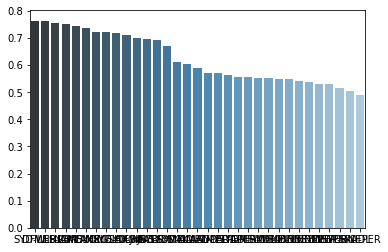

In [251]:
y = [i[0] for i in validationResults]
x = [ "{}-{}".format(i[1],i[2]) for i in validationResults]
sns.barplot(x,y, palette="Blues_d")